In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from playsound import playsound
from shapely.geometry import box

import shapely.geometry as sg
from shapely.geometry import Point

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
yy_s, yy_e = 2002, 2022
# yy_s, yy_e = 2007, 2012
years_num = yy_e - yy_s + 1

# # Test area 1
# lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# # Test area 2
lon_min, lon_max, lat_min, lat_max = 11, 12.5, 45, 46.5
# # Veneto
# lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [5]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")
print(len(wa_pd))

205


In [6]:
total_years = np.arange(1980,2024)
print(f'Quantiles for period: {1980} to {2024}')
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}'
    Weibull_OBS = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['N'].values
        C_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['C'].values
        W_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

Quantiles for period: 1980 to 2024


In [7]:
print(f'Extract Parameters for: {yy_s} to {yy_e}')
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)
N_df.insert(1, 'Lat', wa_pd['Lat'].values)
N_df.insert(2, 'Lon', wa_pd['Lon'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)
C_df.insert(1, 'Lat', wa_pd['Lat'].values)
C_df.insert(2, 'Lon', wa_pd['Lon'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)
W_df.insert(1, 'Lat', wa_pd['Lat'].values)
W_df.insert(2, 'Lon', wa_pd['Lon'].values)

print(len(W_df))

Extract Parameters for: 2002 to 2022
205


In [8]:
Tr = np.array([10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
Q_obs = np.zeros([len(wa_pd), len(Tr)])
File_, Lat_, Lon_, YYS_, YYE_, NY_ = [], [], [], [], [], []

for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]

    File_.append(wa_pd['File_Name'][nn])
    Lat_.append(wa_pd['Lat'][nn])
    Lon_.append(wa_pd['Lon'][nn])
    YYS_.append(yy_s)
    YYE_.append(yy_e)
    NY_.append(years_num - np.sum(np.isnan(N_)))

    x0 = np.nanmean(C_)
    TMP_Q, flags = ART_down.mev_quant_update(Fi, x0, N_, C_, W_, thresh=1)
    TMP_Q = np.where(flags==True,TMP_Q,np.nan)
    Q_obs[nn,:] = TMP_Q

new_df = pd.DataFrame(Q_obs, columns=['Q10','Q20','Q50','Q100','Q200'])
new_df.insert(0, 'File_Name', File_)
new_df.insert(1, 'Lat', Lat_)
new_df.insert(2, 'Lon', Lon_)
new_df.insert(3, 'YYS', YYS_)
new_df.insert(4, 'YYE', YYE_)
new_df.insert(5, 'NY', NY_)

clear_df = new_df[new_df['NY']==years_num]
clear_df = new_df[new_df['NY'] == years_num].reset_index(drop=True)

print(len(clear_df))

148


In [9]:
lon_min_rect, lon_max_rect = lon_min, lon_max
lat_min_rect, lat_max_rect = lat_min, lat_max

# Crear un polígono rectangular
rectangle = sg.Polygon([
    (lon_min_rect, lat_min_rect),
    (lon_max_rect, lat_min_rect),
    (lon_max_rect, lat_max_rect),
    (lon_min_rect, lat_max_rect),
    (lon_min_rect, lat_min_rect)  # Cerrar el polígono
])

rect_gdf = gpd.GeoDataFrame(geometry=[rectangle], crs="EPSG:4326")

In [10]:
# def convert_lat_lon_point(lon_in, lat_in):
#     lon2d, lat2d = np.meshgrid(lon_in, lat_in)
#     points = [Point(lon, lat) for lon, lat in zip(lon2d.ravel(), lat2d.ravel())]
#     points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
    
#     points_in_rect = gpd.sjoin(points_gdf, rect_gdf, how="inner", predicate="within")
    
#     lon_inside = points_in_rect.geometry.x.values  # Longitudes dentro del rectángulo
#     lat_inside = points_in_rect.geometry.y.values  # Latitudes dentro del rectángulo
    
#     lon_indices = [np.argmin(np.abs(lon_in - lon)) for lon in lon_inside]
#     lat_indices = [np.argmin(np.abs(lat_in - lat)) for lat in lat_inside]
    
#     lon_indices = np.unique(lon_indices)
#     lat_indices = np.unique(lat_indices)
    
#     lon2d, lat2d = np.meshgrid(lon_in[lon_indices],lat_in[lat_indices])
    
#     return lon_indices, lat_indices, lon2d, lat2d

In [11]:
# # Stop Notebook
# sys.exit("🛑 The execution of the cell was stopped")

## Compare acf versions (mar and str)

In [12]:
# product, time_reso, spatial_reso, cor_method = 'CMORPH', '3h', '0.25', 'pearson'
# product, time_reso, spatial_reso, cor_method = 'GSMaP', '3h', '0.1', 'pearson'
# product, time_reso, spatial_reso, cor_method = 'IMERG', '1dy', '0.1', 'pearson'
# product, time_reso, spatial_reso, cor_method = 'ERA5', '3h', '0.25', 'pearson'
# product, time_reso, spatial_reso, cor_method = 'PERSIANN', '1dy', '0.25', 'pearson'
# product, time_reso, spatial_reso, cor_method = 'MSWEP', '3h', '0.1', 'pearson'
product, time_reso, spatial_reso, cor_method = 'CHIRPS', '1dy', '0.05', 'pearson'

In [13]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [14]:
# data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_{product}_{time_reso}_2002_2012_npix_1_thr_1_acf_mar_ZOR_{cor_method}.nc')
data_dir = os.path.join(data_base,'5_DOWN',f'VENETO_DOWN_{product}_1dy_{yy_s}_{yy_e+1}_npix_2_thr_1_acf_mar_genetic_{cor_method}.nc')
DATA = xr.open_dataset(data_dir)

# lats = DATA.lat.values
# lons = DATA.lon.values
lats = np.round(DATA.lat.values, 2).astype(np.float32)
lons = np.round(DATA.lon.values, 2).astype(np.float32)
lon2d, lat2d = np.meshgrid(lons, lats)

Tr = DATA.Tr.values

Mevs_mar = DATA.Mev_s.values[3,:,:]
Mevd_mar = DATA.Mev_d.values[3,:,:]

In [15]:
# data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_{product}_{time_reso}_2002_2012_npix_1_thr_1_acf_str_ZOR_{cor_method}.nc')
# data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_{product}_{time_reso}_2002_2012_npix_1_thr_1_acf_mar_ZOR_{cor_method}_CLUSTER.nc')
data_dir = os.path.join(data_base,'5_DOWN',f'VENETO_DOWN_{product}_1dy_{yy_s}_{yy_e+1}_npix_2_thr_1_acf_str_genetic_{cor_method}.nc')
DATA = xr.open_dataset(data_dir)

Mevs_str = DATA.Mev_s.values[3,:,:]
Mevd_str = DATA.Mev_d.values[3,:,:]

In [16]:
# Ajustar las coordenadas para que la grilla esté alineada correctamente
# Desplazamos las coordenadas a la mitad de la resolución para corregir el desplazamiento
Clon_adjusted = lons - (float(spatial_reso) / 2)
Clat_adjusted = lats - (float(spatial_reso) / 2)

# Agregar una fila en la parte superior y una columna a la derecha
# Esto asegura que la grilla cubra toda el área y agregue el borde superior y derecho
# Extender las coordenadas para que cubran toda la grilla correctamente
Clon_adjusted = np.linspace(lons.min() - float(spatial_reso) / 2, lons.max() + float(spatial_reso) / 2, len(lons) + 1)
Clat_adjusted = np.linspace(lats.min() - float(spatial_reso) / 2, lats.max() + float(spatial_reso) / 2, len(lats) + 1)


# Crear las celdas de la grilla utilizando las coordenadas ajustadas
grid_cells = []
for i in range(len(Clon_adjusted) - 1):
    for j in range(len(Clat_adjusted) - 1):
        # Crear una celda de la grilla como un polígono rectangular (cuadrado)
        grid_cells.append(box(Clon_adjusted[i], Clat_adjusted[j], Clon_adjusted[i + 1], Clat_adjusted[j + 1]))

# Crear un GeoDataFrame con las celdas de la grilla
grid_gdf = gpd.GeoDataFrame(
    geometry=grid_cells,
    crs="EPSG:4326"
)

In [17]:
# =============================================================================
wa_gdf = gpd.GeoDataFrame(clear_df, geometry=gpd.points_from_xy(clear_df['Lon'], clear_df['Lat']), crs="EPSG:4326")
wa_inside_rect = gpd.sjoin(wa_gdf, rect_gdf, how="inner", predicate="within")
wa_inside_rect = wa_inside_rect.drop(columns=['index_right'])

# =============================================================================
wa_inside_rect = wa_inside_rect[wa_inside_rect['Q50']<=600]
wa_inside_rect = wa_inside_rect.reset_index(drop=True)

wa_inside_rect.sort_values(by=["Lat", "Lon"], ascending=[True, True], inplace=True)

# QOBS_area_mean = np.nanmean(wa_inside_rect.iloc[:,6:-1].values,axis=0)

Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/OBS_SAT_grid_CHIRPS.png


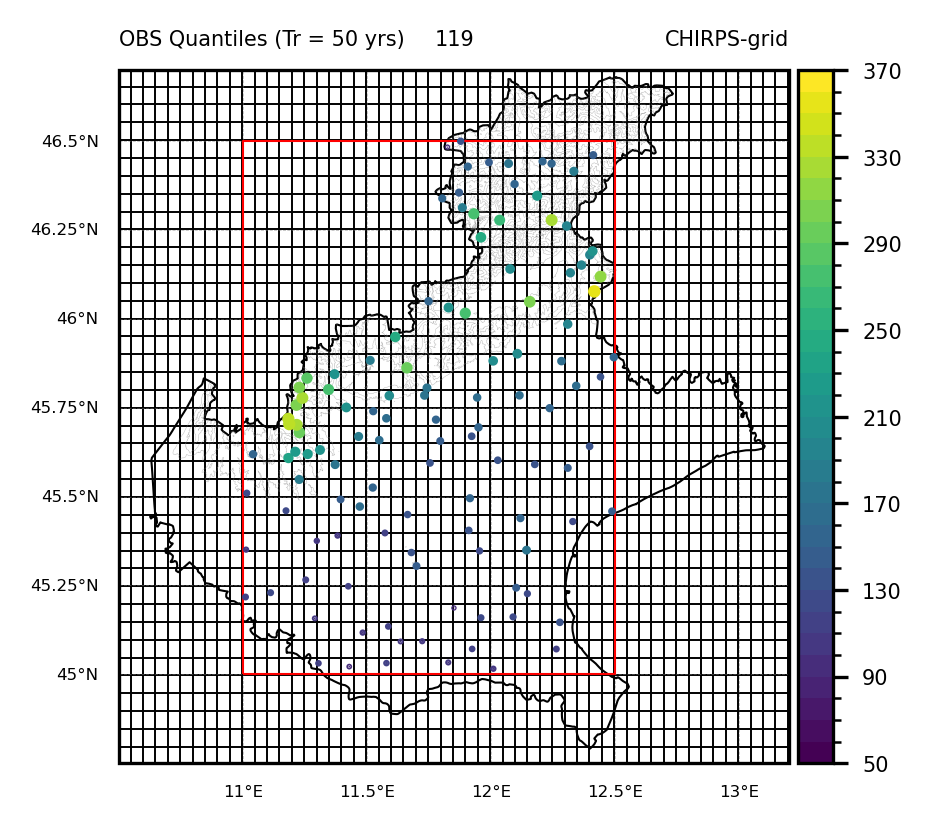

In [18]:
Q50_obs_norm = (wa_inside_rect['Q50']-wa_inside_rect['Q50'].min())/(wa_inside_rect['Q50'].max()-wa_inside_rect['Q50'].min())

levels_obs = np.arange(50,int(np.max(wa_inside_rect['Q50']))+20,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
# ax1.set_extent([11.5, 12.0, 45.85, 46.15],crs=proj)
# ax1.set_extent([12, 12.5, 45.1, 45.6],crs=proj)
# ax1.set_extent([11, 11.5, 45.5, 46],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

grid_gdf.boundary.plot(ax=ax1,linewidth=0.4, edgecolor='black')

# a1 = ax1.scatter(lon2d, lat2d,
#                 s = (Mevd_mar-np.min(Mevd_mar))/(np.max(Mevd_mar)-np.min(Mevd_mar))*5, 
#                 c = Mevd_mar,
#                 marker='s',
#                 norm=norm_obs)

rect_gdf.plot(ax=ax1, edgecolor='r', facecolor='none', linewidth=0.5, zorder=15)
a1 = ax1.scatter(
                wa_inside_rect['Lon'].values, 
                wa_inside_rect['Lat'].values, 
                s=Q50_obs_norm*4, 
                c=wa_inside_rect['Q50'], 
                norm=norm_obs,
                zorder=20, label='Stations')

# # Agregar anotaciones con los valores de Q50
# for lon, lat, q50 in zip(wa_inside_rect['Lon'], wa_inside_rect['Lat'], wa_inside_rect['Q50']):
#     ax1.annotate(
#         f"{q50:.2f}",  # Formato con dos decimales
#         (lon, lat),  # Coordenadas del punto
#         textcoords="offset points",  # Tipo de posicionamiento
#         xytext=(5,5),  # Desplazamiento en píxeles (x, y)
#         ha='center',  # Alineación horizontal
#         fontsize=3,  # Tamaño de la fuente
#         color='black',  # Color del texto
#         bbox=dict(facecolor='None', edgecolor='none', alpha=0.7)  # Fondo blanco semitransparente
#     )

# a1 = ax1.scatter(lons[0],lats[3],s=0.1,c='r')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, ticks= None, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=5)
# cbar.set_label("Acf-MAR (mm)", fontsize=5)

ax1.set_title(f'OBS Quantiles (Tr = 50 yrs)', fontsize=5, loc='left')
ax1.set_title(f'{len(wa_inside_rect)}', fontsize=5, loc='center')
ax1.set_title(f'{product}-grid', fontsize=5, loc='right')

# =========================================================================================================================
salida = os.path.join('/','home','arturo','Pictures','VALIDATION',f'{product}_{time_reso}',f'{cor_method}',f'OBS_SAT_grid_{product}.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

## Test Error Matrix Spatial Mean

In [19]:
points = [Point(lon, lat) for lon, lat in zip(wa_inside_rect['Lon'], wa_inside_rect['Lat'])]
points_gdf = gpd.GeoDataFrame(wa_inside_rect, geometry=points, crs="EPSG:4326")

In [20]:
# Lista para almacenar los resultados
medias_por_box = []

# Iterar sobre cada celda de la grilla (grid_gdf)
for idx, cell in grid_gdf.iterrows():
    # Filtrar los puntos que están dentro de la celda
    puntos_en_celda = points_gdf[points_gdf.geometry.within(cell.geometry)]
    
    if not puntos_en_celda.empty:
        # Calcular la media de Q50 para los puntos dentro de la celda
        media_q50 = puntos_en_celda['Q50'].mean()
        
        # Almacenar los resultados: el índice de la celda y la media calculada
        medias_por_box.append({'box_idx': idx, 'media_Q50': media_q50})

# Convertir los resultados en un DataFrame
resultados_df = pd.DataFrame(medias_por_box)

centroide = grid_gdf.loc[resultados_df['box_idx'], 'geometry'].centroid
lat_centroid = centroide.y  # Latitud
lon_centroid = centroide.x  # Longitud

In [21]:
la_idx, lo_idx = [], []
for la, lo in zip(lat_centroid, lon_centroid):
    la_idx.append(int(np.where(lats==np.round(lat_centroid.values[0],2).astype(np.float32))[0][0]))
    lo_idx.append(int(np.where(lons==np.round(lon_centroid.values[0],2).astype(np.float32))[0][0]))

In [22]:
# la_idx[0],lo_idx[0],resultados_df['media_Q50'][0],Mevd_mar[la_idx[0],lo_idx[0]]
ERROR_matrix = []
for nn in range(len(la_idx)):
    ERROR_matrix.append((Mevd_mar[la_idx[nn],lo_idx[nn]]-resultados_df['media_Q50'][nn])/resultados_df['media_Q50'][nn])

<GeoAxes: >

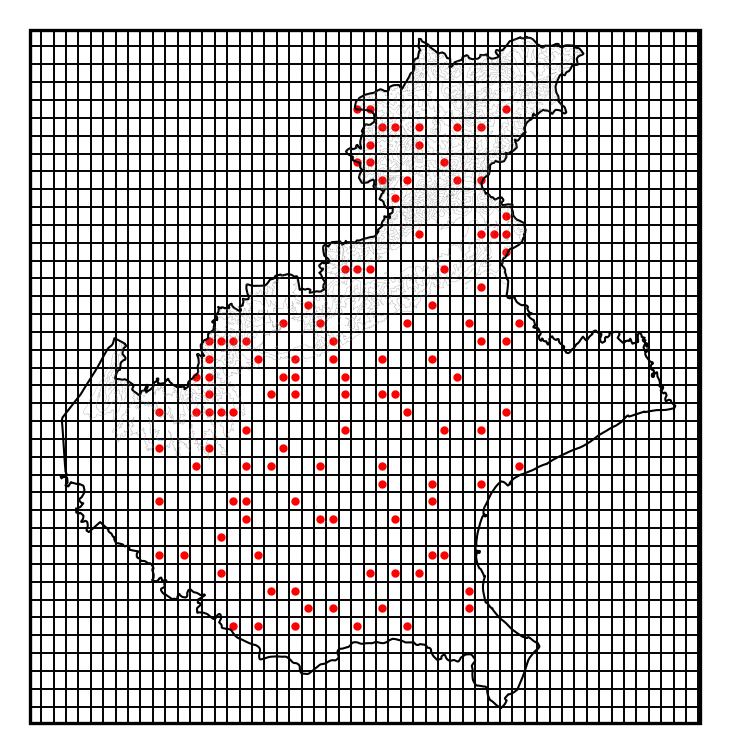

In [23]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

ax1.scatter(lon_centroid,lat_centroid,s=1,color='r')
grid_gdf.boundary.plot(ax=ax1,linewidth=0.4, edgecolor='black')

## QUANTILES ERROR

In [29]:
SAT_Mevs, SAT_Mevd_mar, SAT_Mevd_str = [], [], []
pixel_pos = []

for nn in range(len(wa_inside_rect)):
    Q_OBS = wa_inside_rect['Q50'].values[nn]
    lat_obs = wa_inside_rect['Lat'].values[nn]
    lon_obs = wa_inside_rect['Lon'].values[nn]

    # =======================================================================
    distances = ART_pre.haversine(lat2d, lon2d, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    SAT_Mevs.append(Mevs_mar[min_index[0],min_index[1]])
    SAT_Mevd_mar.append(Mevd_mar[min_index[0],min_index[1]])
    SAT_Mevd_str.append(Mevd_str[min_index[0],min_index[1]])
    pixel_pos.append([int(min_index[0]),int(min_index[1])])

In [30]:
DF_data = pd.DataFrame({
        'Name':wa_inside_rect['File_Name'].values,
        'OBS_lat':wa_inside_rect['Lat'].values,
        'OBS_lon':wa_inside_rect['Lon'].values,
        'OBS_Q50':wa_inside_rect['Q50'].values,
        'SAT_pos':pixel_pos,
        'SAT_Mevs':SAT_Mevs,
        'SAT_Mevd_mar':SAT_Mevd_mar,
        'SAT_Mevd_str':SAT_Mevd_str,
})

DF_data['Mevd_dif']= DF_data['SAT_Mevd_mar']-DF_data['SAT_Mevd_str']

In [31]:
DF_data['E_Mevs'] = (DF_data['SAT_Mevs']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
DF_data['E_Mevd_mar'] = (DF_data['SAT_Mevd_mar']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
DF_data['E_Mevd_str'] = (DF_data['SAT_Mevd_str']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

In [32]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange']

Text(0.5, 0, 'Nearest Satellite Pixel')

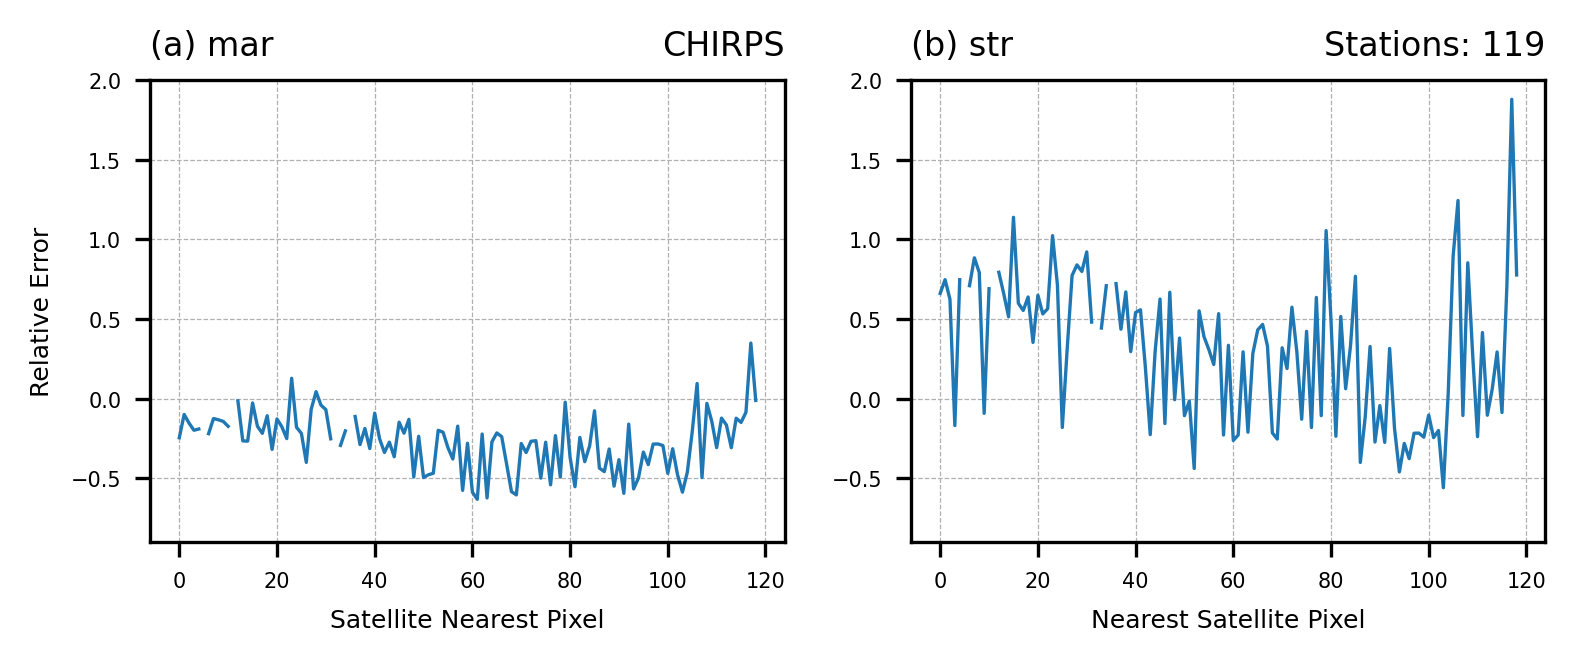

In [33]:
fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ===================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(DF_data['E_Mevd_mar'],linewidth=0.8)

ax1.set_ylim(-0.9,2)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title(f'(a) mar', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')
ax1.set_ylabel('Relative Error',fontsize=6)
ax1.set_xlabel('Satellite Nearest Pixel',fontsize=6)

# ===================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(DF_data['E_Mevd_str'],linewidth=0.8)

ax1.set_ylim(-0.9,2)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title(f'(b) str', fontsize=8, loc='left')
ax1.set_title(f'Stations: {len(DF_data)}', fontsize=8, loc='right')
ax1.set_xlabel('Nearest Satellite Pixel',fontsize=6)

In [34]:
# create a function to histogram
def manual_hist(data_in):
    bins = np.arange(data_in.min(), data_in.max() + 0.1, 0.1)
    frequencies, edges = np.histogram(data_in, bins=bins)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    return bin_centers, frequencies

In [35]:
HIST_Mevs = manual_hist(DF_data['E_Mevs'])
HIST_Mevd_mar = manual_hist(DF_data['E_Mevd_mar'])
HIST_Mevd_str = manual_hist(DF_data['E_Mevd_str'])

In [36]:
SAT_Mevd_mix = []
for nn in range(len(DF_data)):
    if abs(DF_data['E_Mevd_mar'][nn])<abs(DF_data['E_Mevd_str'][nn]):
        SAT_Mevd_mix.append(float(SAT_Mevd_mar[nn]))
    else:
        SAT_Mevd_mix.append(float(SAT_Mevd_str[nn]))

E_Mevd_mix = (SAT_Mevd_mix-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/PDF_Error_CHIRPS.png


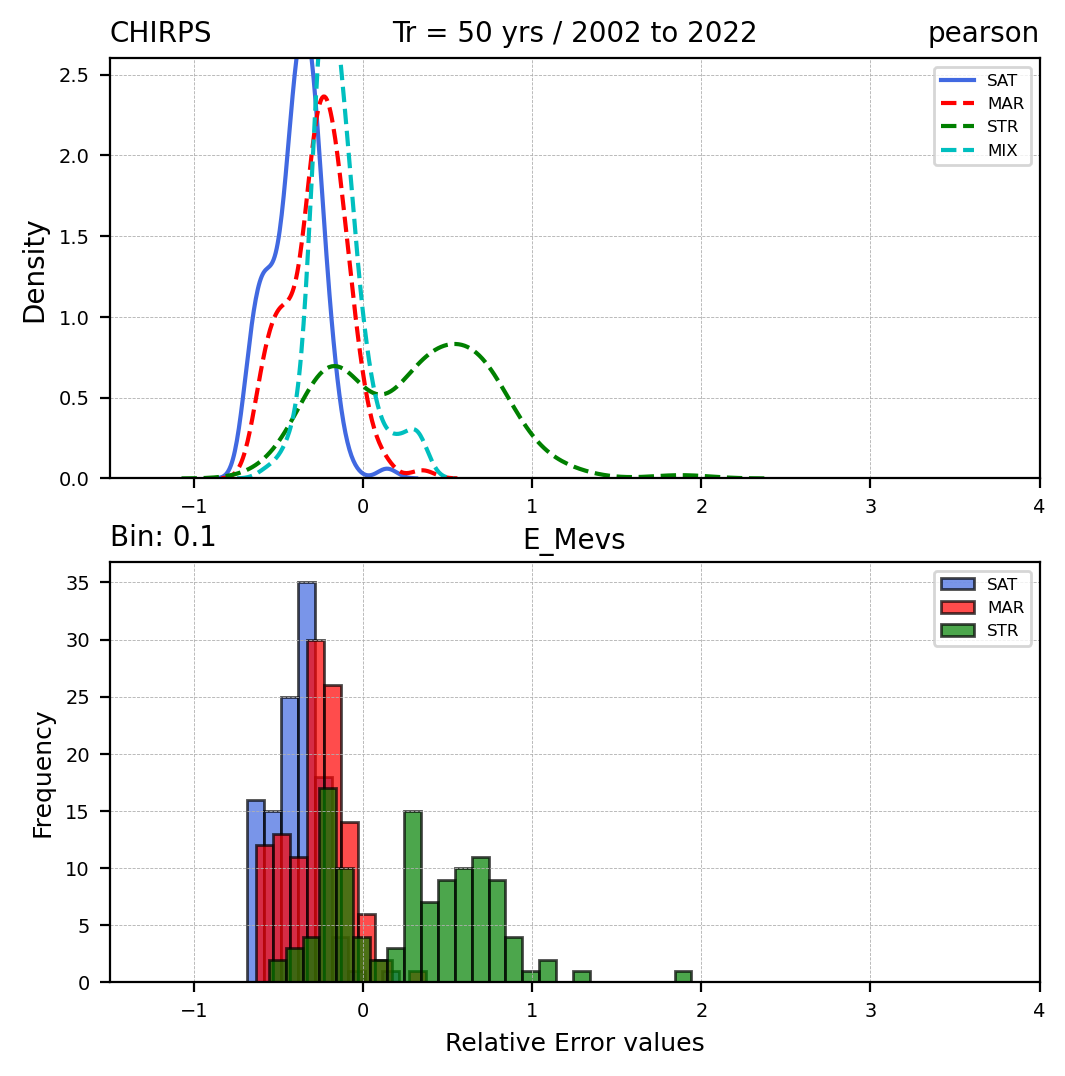

In [39]:
fig = plt.figure(figsize=(6,6),dpi=200)
gs = gridspec.GridSpec(2,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(DF_data['E_Mevs'],color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SAT')
sns.kdeplot(DF_data['E_Mevd_mar'],color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MAR')
sns.kdeplot(DF_data['E_Mevd_str'],color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'STR')
sns.kdeplot(E_Mevd_mix,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MIX')

# sns.kdeplot(ERROR_matrix,color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MATRIX')

ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(product,fontsize=10, loc='left')
ax1.set_title(f'Tr = 50 yrs / {yy_s} to {yy_e}',fontsize=10, loc='Center')
ax1.set_title(f'{cor_method}',fontsize=10, loc='right')

ax1.set_xlim(-1.5,4)
ax1.set_ylim(0,2.6)

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 0])

ax1.bar(HIST_Mevs[0], HIST_Mevs[1], width=0.1, edgecolor='black', color=colors[0], alpha=0.7,label=f'SAT')
ax1.bar(HIST_Mevd_mar[0], HIST_Mevd_mar[1], width=0.1, edgecolor='black', color=colors[1], alpha=0.7,label=f'MAR')
ax1.bar(HIST_Mevd_str[0], HIST_Mevd_str[1], width=0.1, edgecolor='black', color=colors[2], alpha=0.7,label=f'STR')

ax1.set_xlabel("Relative Error values",fontsize=9)
ax1.set_ylabel("Frequency",fontsize=9)
ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.set_title("Bin: 0.1",fontsize=10, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)

ax1.set_xlim(-1.5,4)

# =========================================================================================================================
salida = os.path.join('/','home','arturo','Pictures','VALIDATION',f'{product}_{time_reso}',f'{cor_method}',f'PDF_Error_{product}.png')
print(f'Export figure to: {salida}')
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)


In [40]:
# # Stop Notebook
# sys.exit("🛑 The execution of the cell was stopped")

## Gig to verify two methods (mar and str)

In [41]:
DF_data['Mevd_dif'].max(),DF_data['Mevd_dif'].min()

(np.float64(-3.305597574627086), np.float64(-202.6600947671032))

In [42]:
DF_data = DF_data.dropna(subset=['E_Mevs']).reset_index(drop=True)

In [44]:
levels = np.arange(-1.6,1.8,0.2)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

levels2 = np.arange(-230,20,20)
norm2 = mcolors.BoundaryNorm(boundaries=levels2, ncolors=256)

cmap = plt.cm.Spectral_r
cmap2 = plt.cm.cividis

colors_map = ["darkred", "red", "white", "lightblue", "darkblue"] 
cmap_custom = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors_map, N=256)

proj = ccrs.PlateCarree()

ERROR_DRAW_SAT = []
ERROR_DRAW_DOW = []

error_minimo_contador = [0, 0, 0] 
for pos in range(len(DF_data)): # len(DF_data)

    fig = plt.figure(figsize=(5,4),dpi=300)
    gs = gridspec.GridSpec(2,3)

    # ============================================================================================
    ax1 = plt.subplot(gs[0, 0], projection = proj)
    ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)
    VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
    DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

    a1 = ax1.scatter(DF_data['OBS_lon'][0:pos+1], DF_data['OBS_lat'][0:pos+1], s=abs(DF_data['E_Mevd_mar'][0:pos+1])*10, c=DF_data['E_Mevd_mar'][0:pos+1],zorder=10,cmap=cmap_custom,norm=norm)

    ax1.scatter(
    DF_data['OBS_lon'][pos], 
    DF_data['OBS_lat'][pos], 
    s=abs(DF_data['E_Mevd_mar'][pos]) * 10,  # Tamaño del punto
    c=DF_data['E_Mevd_mar'][pos],
    marker='s',
    zorder=20,
    edgecolors='k',
    linewidth=0.1,
    cmap=cmap_custom,norm=norm
    )

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.left_labels =True
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    ax1.set_title('(a) MAR',fontsize=6,loc='left')
    ax1.set_title(f'Id: {str(pos).zfill(3)}',fontsize=6,loc='right')

    # ============================================================================================
    ax1 = plt.subplot(gs[0, 1], projection = proj)
    ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)
    VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
    DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

    a1 = ax1.scatter(DF_data['OBS_lon'][0:pos+1], DF_data['OBS_lat'][0:pos+1], s=abs(DF_data['E_Mevd_str'][0:pos+1])*10, c=DF_data['E_Mevd_str'][0:pos+1],zorder=10,cmap=cmap_custom,norm=norm)

    ax1.scatter(
    DF_data['OBS_lon'][pos], 
    DF_data['OBS_lat'][pos], 
    s=abs(DF_data['E_Mevd_str'][pos]) * 10,  # Tamaño del punto
    c=DF_data['E_Mevd_str'][pos],
    marker='s',
    zorder=20,
    edgecolors='k',
    linewidth=0.1,
    cmap=cmap_custom,norm=norm
    )

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.left_labels =False
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    ax1.set_title('(b) STR',fontsize=6,loc='left')
    ax1.set_title(f'{product} ({spatial_reso}°)',fontsize=6,loc='right')
    
    # ============================================================================================
    ax1 = plt.subplot(gs[0, 2], projection = proj)
    ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)
    VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
    DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

    dif_norm = (DF_data['Mevd_dif'] - DF_data['Mevd_dif'].min())/(DF_data['Mevd_dif'].max()-DF_data['Mevd_dif'].min())
    a2 = ax1.scatter(DF_data['OBS_lon'][0:pos+1], DF_data['OBS_lat'][0:pos+1], s=abs(1-dif_norm[0:pos+1]*0.5)*2, c=DF_data['Mevd_dif'][0:pos+1],zorder=10,cmap=cmap2,norm=norm2)

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.left_labels =False
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}
    
    ax1.set_title(f'(c) Quantile dif (MAR-STR)',fontsize=6,loc='left')

    # ============================================================================================
    ax1 = plt.subplot(gs[1, 0:2])

    etiquetas = ['OBS', 'SAT', 'MAR', 'STR']
    valores = [
    DF_data['OBS_Q50'][pos], 
    DF_data['SAT_Mevs'][pos], 
    DF_data['SAT_Mevd_mar'][pos],
    DF_data['SAT_Mevd_str'][pos]]

    errores = [0, DF_data['E_Mevs'][pos], DF_data['E_Mevd_mar'][pos], DF_data['E_Mevd_str'][pos]]

    errores_relevantes = errores[1:] 
    indice_menor_error = np.argmin(np.abs(errores_relevantes)) 
    error_minimo_contador[indice_menor_error] += 1

    barras = ax1.bar(etiquetas, valores, color=['k', colors[0], colors[1], colors[2]])

    for i, (bar, error) in enumerate(zip(barras, errores)):

        altura = bar.get_height()/2  # Obtener altura de la barra
        ax1.annotate(f'{error:.2f}',  # Texto del error
                    xy=(bar.get_x() + bar.get_width() / 2, altura),  # Posición en la barra
                    xytext=(0, 3),  # Desplazamiento en y
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7, color='black')

        if i > 0:
            ax1.annotate(f'{error_minimo_contador[i-1]}',  
                        xy=(bar.get_x() + bar.get_width() / 2, altura - 25),  
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=7, color='black')

    ax1.set_title(f'(d) Quantiles (Tr=50yrs)',fontsize=6,loc='left')
    ax1.set_title(DF_data['SAT_pos'][pos],fontsize=6,loc='center')

    if DF_data['OBS_Q50'][pos]<DF_data['SAT_Mevs'][pos]:
        ax1.set_title(DF_data['Name'][pos].replace('.csv',''),fontsize=5,c='r',loc='right')
    else:
        ax1.set_title(DF_data['Name'][pos].replace('.csv',''),fontsize=5,loc='right')

    ax1.set_ylim(0,400)
    ax1.tick_params(axis='both', which='major', labelsize=4)
    ax1.grid(linewidth=0.3, linestyle='--',alpha=0.4)
    
    # ============================================================================================
    ax1 = plt.subplot(gs[1, 2])
    sns.kdeplot(DF_data['E_Mevs'][0:pos+1],color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SAT')
    sns.kdeplot(DF_data['E_Mevd_mar'][0:pos+1],color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MAR')
    sns.kdeplot(DF_data['E_Mevd_str'][0:pos+1],color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'STR')

    ax1.set_xlim(-1.5,4)
    ax1.set_ylim(0,3)
    ax1.set_ylabel('')
    ax1.tick_params(axis='both', which='major', labelsize=4)
    ax1.grid(linewidth=0.3, linestyle='--',alpha=0.4)
    ax1.legend(fontsize=4,loc=0)
    
    ax1.set_title(f'(e) Relative Error',fontsize=6,loc='left')
    
    # =================================================================
    cbar_ax = fig.add_axes([0.126, 0.52, 0.496, 0.025])
    cbar = plt.colorbar(a1, cax=cbar_ax, ticks= None, orientation='horizontal')
    cbar.ax.tick_params(labelsize=4)

    cbar_ax = fig.add_axes([0.68, 0.52, 0.218, 0.025])
    cbar = plt.colorbar(a2, cax=cbar_ax, ticks= None, orientation='horizontal')
    cbar.ax.tick_params(labelsize=4)

    # ============================================================================================
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.37, wspace=0.25)

    salida = os.path.join('/','home','arturo','Pictures','VALIDATION',f'{product}_{time_reso}',f'{cor_method}','acf',f'ACF_Error_{product}_{str(pos).zfill(3)}.png')
    print(f'Export figure to: {salida}')
    plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

    plt.close()

Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_000.png
Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_001.png
Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_002.png
Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_003.png
Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_004.png
Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_005.png
Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_006.png
Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_007.png
Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_008.png
Export figure to: /home/arturo/Pictures/VALIDATION/CHIRPS_1dy/pearson/acf/ACF_Error_CHIRPS_009.png
Export fig

In [38]:
playsound("../sound/HOMER_DOH.mp3")

In [39]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Check individual station

In [ ]:
station_name = 'IT-340_262_BL_Va_0005min.csv'

In [ ]:
data_obs_1dy = pd.read_csv(os.path.join(OBS_base, 'Veneto', 'DATA', '1dy_Flag', station_name))
data_obs_1dy['date'] = pd.to_datetime(data_obs_1dy['date'])
data_obs_1dy[data_obs_1dy['Prec_diario']==np.max(data_obs_1dy['Prec_diario'])]

,Unnamed: 0,date,Prec_diario,Num_datos
3694,3694,2014-11-05,401.0,288


In [ ]:
data_obs_5min = pd.read_csv(os.path.join(OBS_base, 'Veneto', 'DATA', '5min', station_name))
data_obs_5min['Datetime'] = pd.to_datetime(data_obs_5min['Datetime'])

In [ ]:
data_1dy_cut = data_obs_1dy[(data_obs_1dy['date'] >= '2014-11-04') & (data_obs_1dy['date'] <= '2014-11-06')]
data_5min_cut = data_obs_5min[(data_obs_5min['Datetime'] >= '2014-11-05 00:00:00') & (data_obs_5min['Datetime'] <= '2014-11-05 23:55:00')]

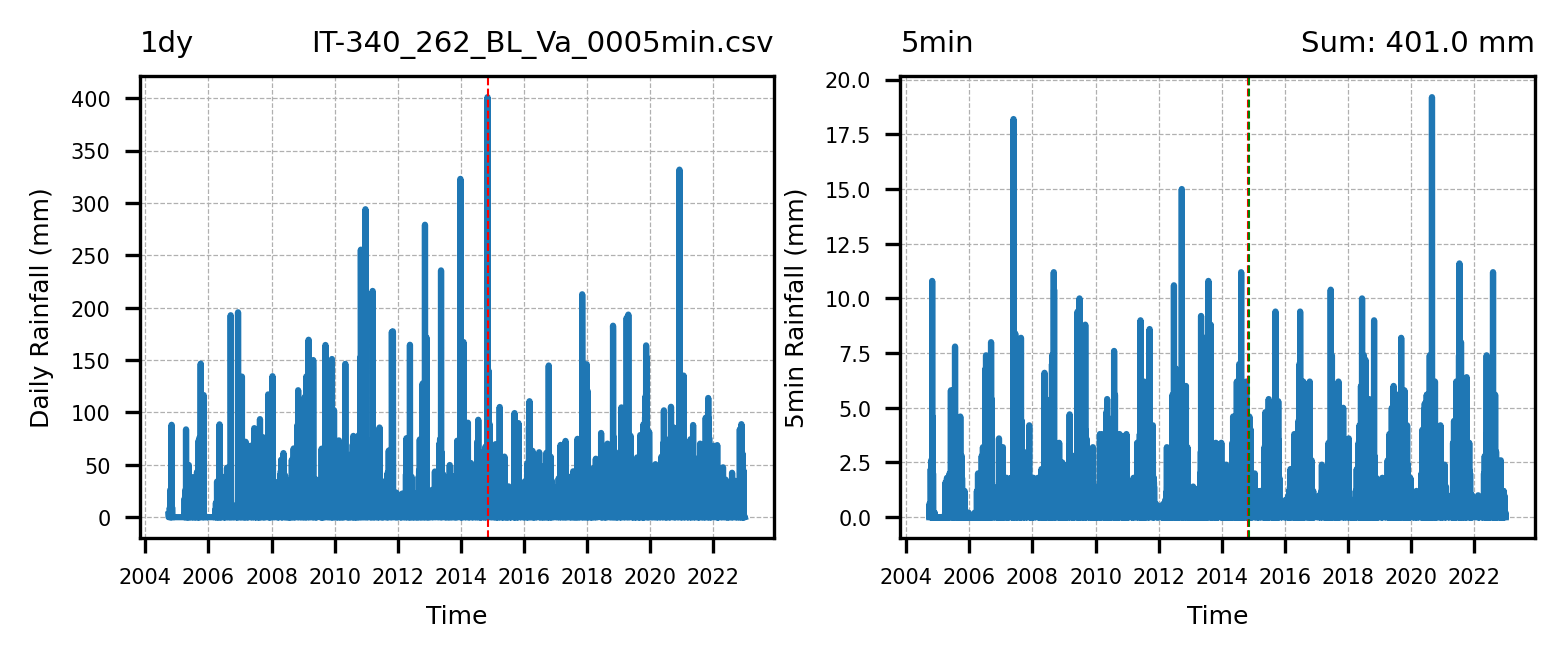

In [ ]:
x_labels_ = [timestamp.strftime('%Y-%m-%d') for timestamp in data_1dy_cut['date']]
fecha_inicio = pd.Timestamp('2014-11-05 00:00:00')
fecha_fin = pd.Timestamp('2014-11-05 23:55:00')

fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(data_obs_1dy['date'],data_obs_1dy['Prec_diario'])
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('1dy',fontsize=7,loc='left')
ax1.set_title(station_name,fontsize=7,loc='right')
plt.xticks(rotation=0)
ax1.grid(linewidth=0.3,linestyle='--')
ax1.set_xlabel('Time',fontsize=6)
ax1.set_ylabel('Daily Rainfall (mm)',fontsize=6)
ax1.axvline(x=fecha_inicio, color='r', linestyle='--', linewidth=0.5, label='Inicio: 2014-11-05 00:00')

ax1 = plt.subplot(gs[0, 1])
ax1.plot(data_obs_5min['Datetime'], data_obs_5min['Prec'])
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('5min',fontsize=7,loc='left')
ax1.set_title(f'Sum: {data_5min_cut['Prec'].sum()} mm',fontsize=7,loc='right')
ax1.set_xlabel('Time',fontsize=6)
ax1.set_ylabel('5min Rainfall (mm)',fontsize=6)
ax1.grid(linewidth=0.3,linestyle='--')

ax1.axvline(x=fecha_inicio, color='r', linestyle='--', linewidth=0.5, label='Inicio: 2014-11-05 00:00')
ax1.axvline(x=fecha_fin, color='g', linestyle='--', linewidth=0.5, label='Fin: 2014-11-05 23:55')

# ax1.set_xlim([pd.Timestamp('2014-11-04 00:00:00'), pd.Timestamp('2014-11-06 23:55:00')])

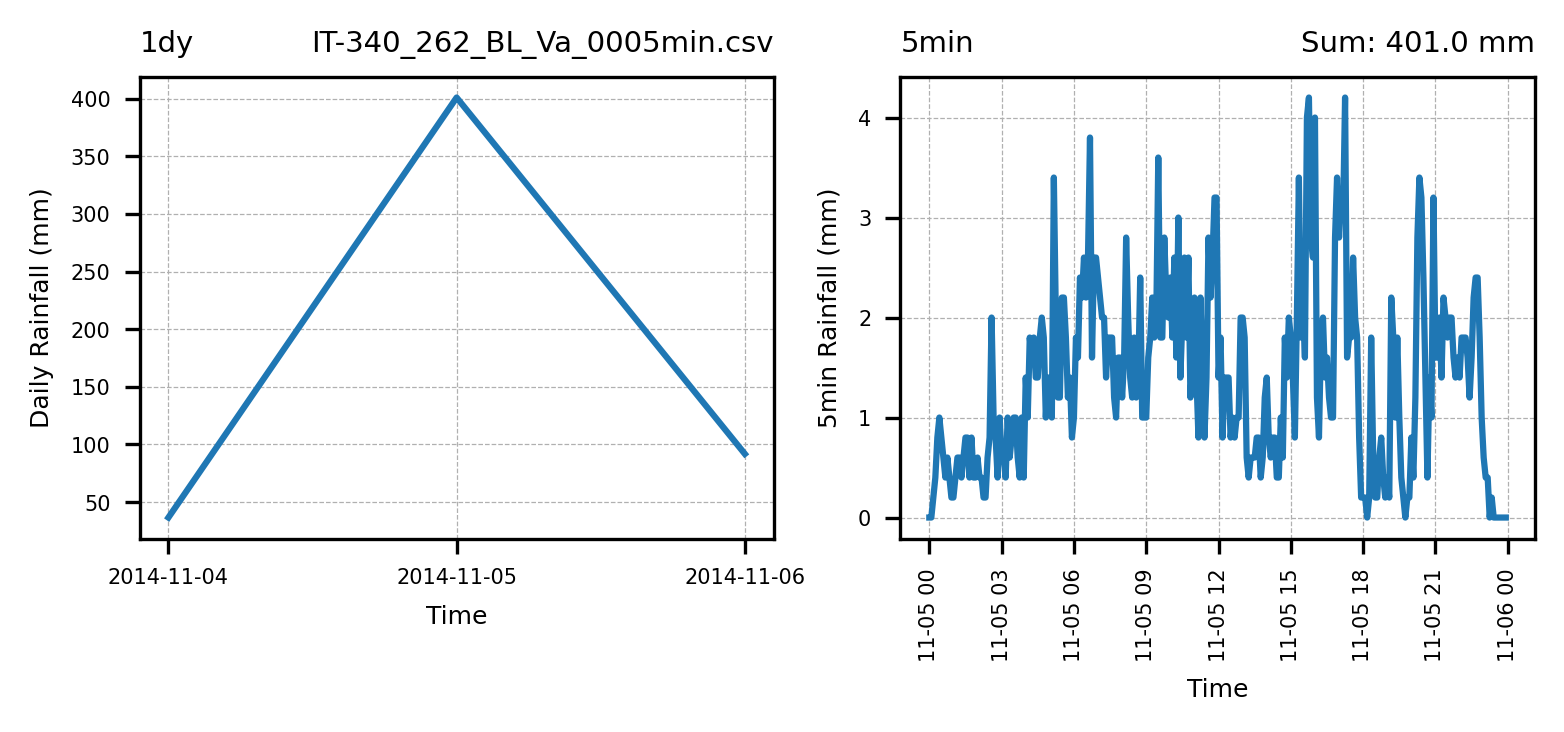

In [ ]:
x_labels_ = [timestamp.strftime('%Y-%m-%d') for timestamp in data_1dy_cut['date']]

fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(data_1dy_cut['date'], data_1dy_cut['Prec_diario'])
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('1dy',fontsize=7,loc='left')
ax1.set_title(station_name,fontsize=7,loc='right')
plt.xticks(rotation=0)
ax1.set_xticks(x_labels_)
ax1.set_xticklabels(x_labels_)
ax1.grid(linewidth=0.3,linestyle='--')
ax1.set_xlabel('Time',fontsize=6)
ax1.set_ylabel('Daily Rainfall (mm)',fontsize=6)

ax1 = plt.subplot(gs[0, 1])
ax1.plot(data_5min_cut['Datetime'], data_5min_cut['Prec'])
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('5min',fontsize=7,loc='left')
ax1.set_title(f'Sum: {data_5min_cut['Prec'].sum()} mm',fontsize=7,loc='right')
ax1.set_xlabel('Time',fontsize=6)
ax1.set_ylabel('5min Rainfall (mm)',fontsize=6)
plt.xticks(rotation=90)
ax1.grid(linewidth=0.3,linestyle='--')

In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

## To Compare Code versions (ART and ZOR)

In [ ]:
product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'

# product, time_reso = 'GSMaP', '3h'
# product, time_reso = 'MSWEP', '3h'

# product, time_reso = 'IMERG', '1dy'

In [ ]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [ ]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_{product}_{time_reso}_2002_2012_npix_1_thr_1_acf_str_ZOR.nc')
DATA = xr.open_dataset(data_dir)

lats = DATA.lat.values
lons = DATA.lon.values
lon2d, lat2d = np.meshgrid(lons, lats)

Tr = DATA.Tr.values

Mevs_zor = DATA.Mev_s.values[3,:,:]
Mevd_zor = DATA.Mev_d.values[3,:,:]

In [ ]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_{product}_{time_reso}_2002_2012_npix_1_thr_1_acf_str_ART.nc')
DATA = xr.open_dataset(data_dir)

Mevs_art = DATA.Mev_s.values[3,:,:]
Mevd_art = DATA.Mev_d.values[3,:,:]

In [ ]:
SAT_Mevs, SAT_Mevd_zor, SAT_Mevd_art = [], [], []

for nn in range(len(wa_inside_rect)):
    Q_OBS = wa_inside_rect['Q50'].values[nn]
    lat_obs = wa_inside_rect['Lat'].values[nn]
    lon_obs = wa_inside_rect['Lon'].values[nn]

    # =======================================================================
    distances = ART_pre.haversine(lat2d, lon2d, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    SAT_Mevs.append(Mevs_zor[min_index[0],min_index[1]])
    SAT_Mevd_zor.append(Mevd_zor[min_index[0],min_index[1]])
    SAT_Mevd_art.append(Mevd_art[min_index[0],min_index[1]])


In [ ]:
DF_data = pd.DataFrame({
        'Name':wa_inside_rect['File_Name'].values,
        'OBS_lat':wa_inside_rect['Lat'].values,
        'OBS_lon':wa_inside_rect['Lon'].values,
        'OBS_Q50':wa_inside_rect['Q50'].values,
        'SAT_Mevs':SAT_Mevs,
        'SAT_Mevd_zor':SAT_Mevd_zor,
        'SAT_Mevd_art':SAT_Mevd_art,
})

In [ ]:
E_Mevs = (DF_data['SAT_Mevs']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
E_Mevd_zor = (DF_data['SAT_Mevd_zor']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
E_Mevd_art = (DF_data['SAT_Mevd_art']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

In [ ]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange']

Text(0.5, 0, 'Nearest Satellite Pixel')

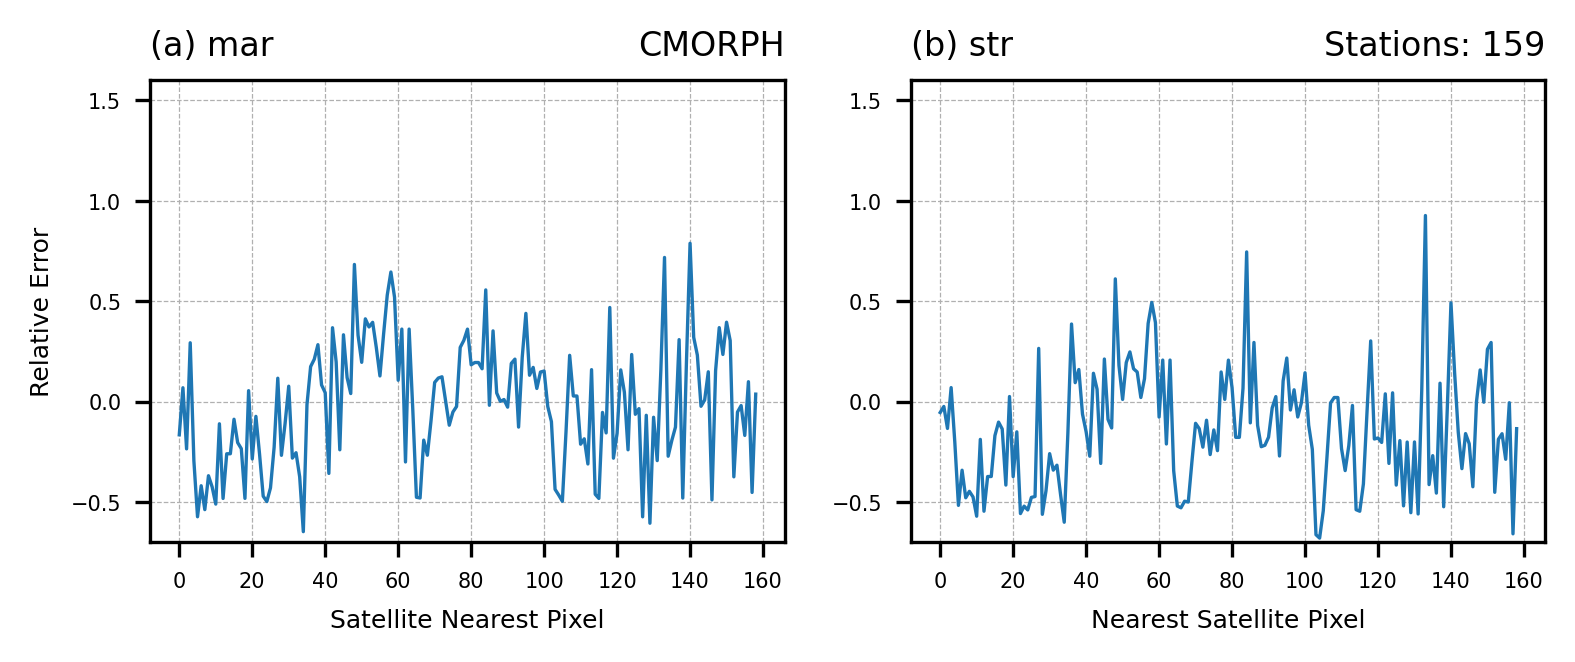

In [ ]:
fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ===================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(E_Mevd_zor,linewidth=0.8)

ax1.set_ylim(-0.7,1.6)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title(f'(a) mar', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')
ax1.set_ylabel('Relative Error',fontsize=6)
ax1.set_xlabel('Satellite Nearest Pixel',fontsize=6)

# ===================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(E_Mevd_art,linewidth=0.8)

ax1.set_ylim(-0.7,1.6)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title(f'(b) str', fontsize=8, loc='left')
ax1.set_title(f'Stations: {len(DF_data)}', fontsize=8, loc='right')
ax1.set_xlabel('Nearest Satellite Pixel',fontsize=6)

In [ ]:
# create a function to histogram
def manual_hist(data_in):
    bins = np.arange(data_in.min(), data_in.max() + 0.1, 0.1)
    frequencies, edges = np.histogram(data_in, bins=bins)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    return bin_centers, frequencies

In [ ]:
HIST_Mevs = manual_hist(E_Mevs)
HIST_Mevd_zor = manual_hist(E_Mevd_zor)
HIST_Mevd_art = manual_hist(E_Mevd_art)

Export figure to: /home/arturo/Pictures/VALIDATION/CMORPH/PDF_Error_CMORPH.png


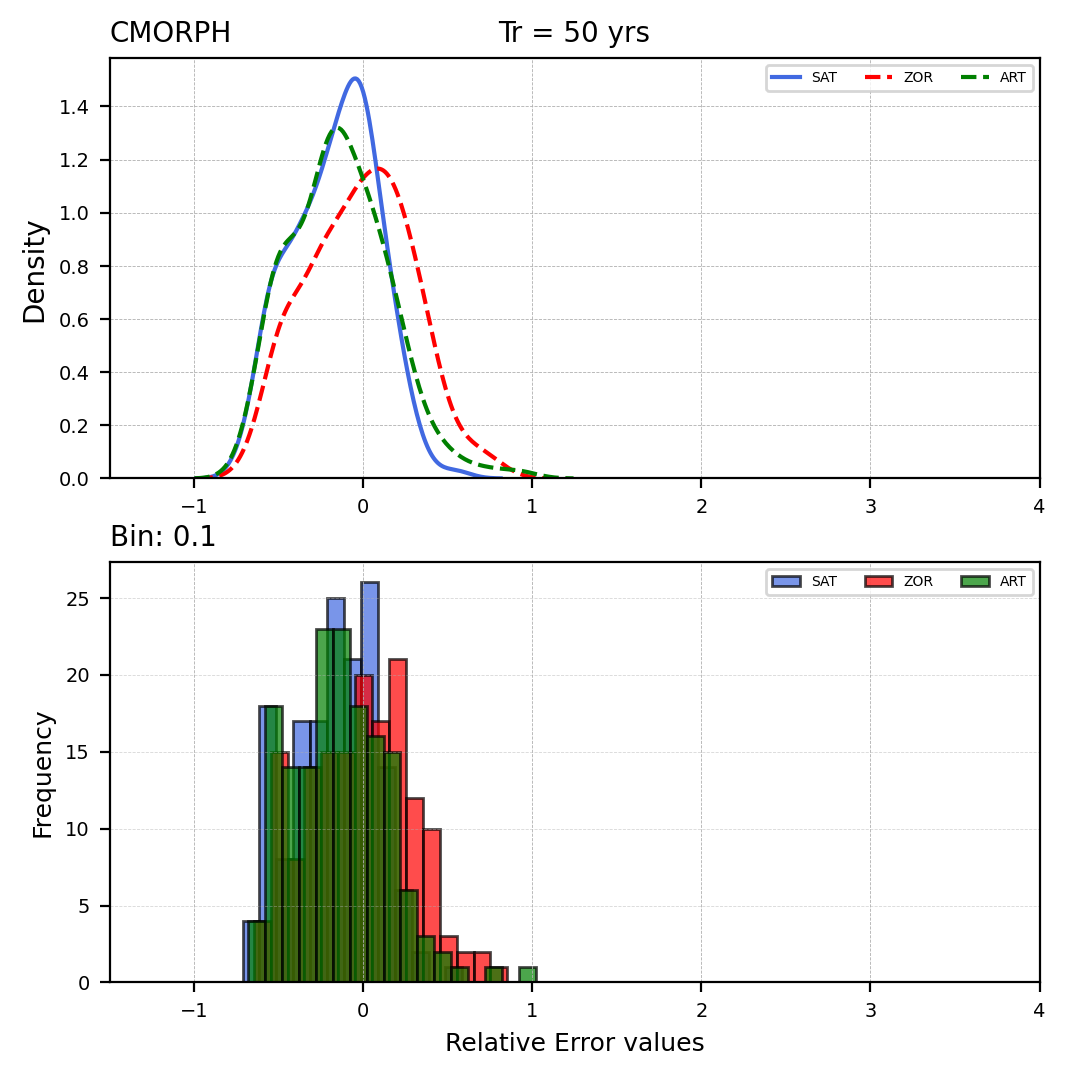

In [ ]:
fig = plt.figure(figsize=(6,6),dpi=200)
gs = gridspec.GridSpec(2,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(E_Mevs,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SAT')
sns.kdeplot(E_Mevd_zor,color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ZOR')
sns.kdeplot(E_Mevd_art,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ART')

ax1.legend(fontsize=5, loc=0, ncol=3)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(product,fontsize=10, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=10, loc='Center')

ax1.set_xlim(-1.5,4)

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 0])

ax1.bar(HIST_Mevs[0], HIST_Mevs[1], width=0.1, edgecolor='black', color=colors[0], alpha=0.7,label=f'SAT')
ax1.bar(HIST_Mevd_zor[0], HIST_Mevd_zor[1], width=0.1, edgecolor='black', color=colors[1], alpha=0.7,label=f'ZOR')
ax1.bar(HIST_Mevd_art[0], HIST_Mevd_art[1], width=0.1, edgecolor='black', color=colors[2], alpha=0.7,label=f'ART')

ax1.set_xlabel("Relative Error values",fontsize=9)
ax1.set_ylabel("Frequency",fontsize=9)
ax1.legend(fontsize=5, loc=0, ncol=3)
ax1.set_title("Bin: 0.1",fontsize=10, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)

ax1.grid(axis='y', linestyle="--", alpha=0.5)

ax1.set_xlim(-1.5,4)

# =========================================================================================================================
salida = os.path.join('/','home','arturo','Pictures','VALIDATION',product,f'PDF_Error_{product}_ZOR_ART.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)


NameError: name 'E_Mevd_zor' is not defined

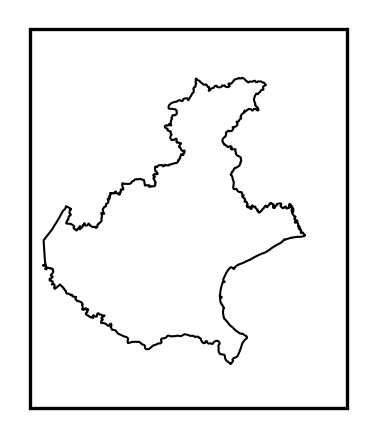

In [ ]:
levels = np.arange(-0.6,1.7,0.2)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

# ticks = np.arange(-60,100,40)

cmap = plt.cm.Spectral_r
# cmap = plt.cm.RdBu


proj = ccrs.PlateCarree()

ERROR_DRAW_SAT = []
ERROR_DRAW_DOW = []

error_minimo_contador = [0, 0, 0] 

count = 0
for pos in range(len(DF_data)):#len(DF_data)

    fig = plt.figure(figsize=(3,4),dpi=300)
    gs = gridspec.GridSpec(2,2)

    # ============================================================================================
    ax1 = plt.subplot(gs[0, 0], projection = proj)
    ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)
    VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

    a1 = ax1.scatter(DF_data['OBS_lon'][0:count], DF_data['OBS_lat'][0:count], s=abs(E_Mevd_zor[0:count])*10, c=E_Mevd_zor[0:count]*100,zorder=10,cmap=cmap,norm=norm)
    
    ax1.scatter(
    DF_data['OBS_lon'][count], 
    DF_data['OBS_lat'][count], 
    s=abs(E_Mevd_zor[count]) * 10,  # Tamaño del punto
    c=E_Mevd_zor[count]*100,
    marker='s',
    zorder=20,
    edgecolors='k',
    linewidth=0.1,
    cmap=cmap,norm=norm
    )
    
    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.left_labels =True
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    ax1.set_title('(a) ZOR',fontsize=6,loc='left')
    ax1.set_title(f'Id: {str(count).zfill(3)}',fontsize=6,loc='right')

    # ============================================================================================
    ax1 = plt.subplot(gs[0, 1], projection = proj)
    ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)
    VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

    a1 = ax1.scatter(DF_data['OBS_lon'][0:count], DF_data['OBS_lat'][0:count], s=abs(E_Mevd_art[0:count])*10, c=E_Mevd_art[0:count]*100,zorder=10,cmap=cmap,norm=norm)
    
    ax1.scatter(
    DF_data['OBS_lon'][count], 
    DF_data['OBS_lat'][count], 
    s=abs(E_Mevd_art[count]) * 10,  # Tamaño del punto
    c=E_Mevd_art[count]*100,
    marker='s',
    zorder=20,
    edgecolors='k',
    linewidth=0.1,
    cmap=cmap,norm=norm
    )

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.left_labels =False
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    ax1.set_title('(b) ART',fontsize=6,loc='left')
    ax1.set_title(product,fontsize=6,loc='right')

    # ============================================================================================
    ax1 = plt.subplot(gs[1, 0:])

    etiquetas = ['OBS', 'SAT', 'ZOR', 'ART']
    valores = [
    DF_data['OBS_Q50'][count], 
    DF_data['SAT_Mevs'][count], 
    DF_data['SAT_Mevd_zor'][count],
    DF_data['SAT_Mevd_art'][count]]

    errores = [0, E_Mevs[count], E_Mevd_zor[count], E_Mevd_art[count]]
    
    errores_relevantes = errores[1:] 
    indice_menor_error = np.argmin(np.abs(errores_relevantes)) 
    error_minimo_contador[indice_menor_error] += 1

    barras = ax1.bar(etiquetas, valores, color=['k', 'blue', 'red', 'green'])

    for i, (bar, error) in enumerate(zip(barras, errores)):

        altura = bar.get_height()/2  # Obtener altura de la barra
        ax1.annotate(f'{error:.2f}',  # Texto del error
                    xy=(bar.get_x() + bar.get_width() / 2, altura),  # Posición en la barra
                    xytext=(0, 3),  # Desplazamiento en y
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7, color='black')

        if i > 0:
            ax1.annotate(f'{error_minimo_contador[i-1]}',  
                        xy=(bar.get_x() + bar.get_width() / 2, altura - 25),  
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=7, color='black')

    ax1.set_title(f'(c) Quantiles for Tr = 50 yrs',fontsize=6,loc='left')
    
    if indice_menor_error == 0:
        ax1.set_title(DF_data['Name'][count],fontsize=6,c='r',loc='right')
    else:
        ax1.set_title(DF_data['Name'][count],fontsize=6,loc='right')
    
    ax1.tick_params(axis='both', which='major', labelsize=4)
    ax1.grid(linewidth=0.3, linestyle='--',alpha=0.4)

    # =================================================================
    cbar_ax = fig.add_axes([0.92, 0.5315, 0.025, 0.33])#0.92
    cbar = plt.colorbar(a1, cax=cbar_ax, ticks= None, orientation='vertical')
    cbar.ax.tick_params(labelsize=5)

    # ============================================================================================
    # if count > 0:
    salida = os.path.join('/','home','arturo','Pictures','VALIDATION',product,'version',f'ACF_Error_{product}_{str(count).zfill(3)}.png')
    print(f'Export figure to: {salida}')
    # plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

    count += 1
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.1)

    # plt.close()


In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Gif to verify only one method (mar or str)

In [ ]:
levels = np.arange(-0.5,1.7,0.2)
# ticks = np.arange(-60,100,40)
cmap = plt.cm.Spectral_r

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

ERROR_DRAW_SAT = []
ERROR_DRAW_DOW = []

count = 10
for pos in range(10):#len(DF_data)
    cmap = plt.cm.Spectral_r
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(4,2),dpi=300)
    gs = gridspec.GridSpec(1,2)

    # ============================================================================================
    ax1 = plt.subplot(gs[0, 0], projection = proj)
    ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)
    VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
    
    if count > 3:
        a1 = ax1.scatter(DF_data['OBS_lon'][0:count], DF_data['OBS_lat'][0:count], s=abs(IMERG_QEd[0:count])*10, c=IMERG_QEd[0:count]*100,norm=norm,cmap=cmap)
    
        cbar = plt.colorbar(a1, ticks=None, orientation='horizontal', fraction=0.053)
        cbar.set_label('Relative Error [%]',fontsize=4)
        cbar.ax.tick_params(labelsize=4)
    
    ax1.set_title(f'Station Id: {str(count).zfill(3)}',fontsize=6,loc='left')
    ax1.set_title(method,fontsize=6,loc='right')

    # ============================================================================================
    ax1 = plt.subplot(gs[0, 1])
    
    if count != 0:
        ERROR_DRAW_SAT.extend((DF_data['IMERG_Q50s'][0:count].values-DF_data['OBS_Q50'][0:count].values)/DF_data['OBS_Q50'][0:count].values)
        ERROR_DRAW_DOW.extend((DF_data['IMERG_Q50d'][0:count].values-DF_data['OBS_Q50'][0:count].values)/DF_data['OBS_Q50'][0:count].values)

        df = pd.DataFrame({'ERRORs':ERROR_DRAW_SAT, 'ERRORd':ERROR_DRAW_DOW})
        sns.violinplot(data=df,ax=ax1)

        ax1.tick_params(axis='both', which='major', labelsize=4)
        ax1.grid(linewidth=0.2, linestyle='--')
        ax1.set_ylim(-0.85,2)    

        salida = os.path.join('/','home','arturo','Pictures','VALIDATION','violin_plot',method,f'Relative_Error_IMERG_{str(count).zfill(3)}.png')
        print(f'Export figure to: {salida}')
        # plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)
    
    count += 1
    
    # plt.close()
    